In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
import pickle
import timeit
from td_algorithm_funcs import get_prop_v2,get_prop_abs_v2, get_hists_v4, get_rate, simulate_traj

# Solve as two dimensional

## One example

In [77]:
k = 3
tau = 0.1
D = 1e-6
s = np.sqrt(2*D)
N_t = 100
dt = tau/4 if tau > 0 else 5e-2
dx = 4e-4 #1e-4


ntau = round(tau/dt)
ts = np.arange(0,N_t)*dt
ts_r = ts[1:]

sb = 0.005
# include zero as x point
# x_s = np.arange(-sb,sb+1e-5,dx)
# bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)

# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)

N_border = np.argmin(x_s**2) + 1 #(first after border) -> partices are going there nothing comes back

N_t = len(ts)
N_x = len(x_s)

# def force(x,*args):
#     return -k*x

# def force(x,*args):
#     return -k*x**3*1e6

# border = 0.0014
# def cusp_force(x):
#     if x < 0:
#         return -k*(x+border)
#     else:
#         return -k*(x-border)
# force = np.vectorize(cusp_force)

v_min = -1e-6
border = 0.0018
def force(x):
    a = -v_min/border**4
    b = -2*v_min/border**2
    return -4*a*x**3+2*b*x

i_zero = np.argmin((x_s+border)**2)

In [78]:
prop = get_prop_v2(x_s, force,D,dt,dx)
prop_abs = get_prop_abs_v2(x_s, force,D,dt,dx,N_border)

hists, unaltered_props, total_prob = get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop)
hists_abs, unaltered_props_abs, total_prob_abs = get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop_abs)

  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (11438,)


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (5916,)


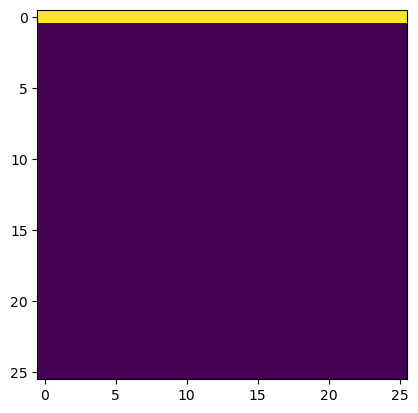

In [79]:
plt.imshow(prop[-1])

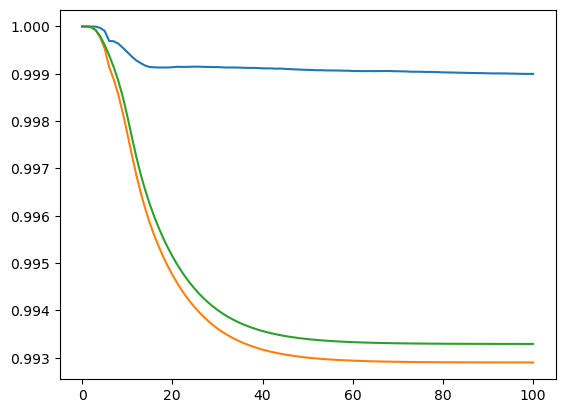

In [80]:
plt.plot(total_prob)
plt.plot(total_prob_abs)
plt.plot(unaltered_props_abs)

In [81]:
np.prod(total_prob), np.prod(total_prob_abs), np.prod(unaltered_props_abs)

(0.9188730347185643, 0.5480296714975417, 0.5687250997861384)

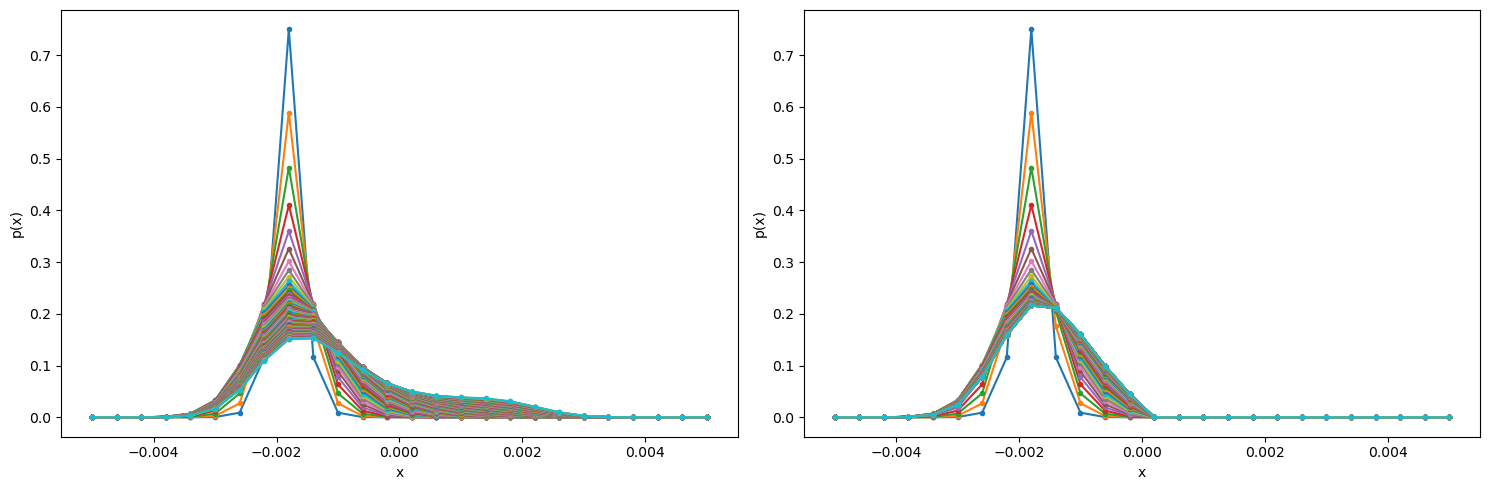

In [82]:
plt.figure(figsize=(15,5))
plt.subplot(121)
for hist in hists:
    plt.plot(x_s,hist,'.-')
plt.xlabel('x')
plt.ylabel('p(x)')
    
plt.subplot(122)
for hist,p in zip(hists_abs,np.cumprod(unaltered_props_abs)[1:]):
    plt.plot(x_s,hist,'.-')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.tight_layout()


In [83]:
f = 5
N_p = 60_000
ts_sim = np.arange(0,(N_t+ntau+2)*f)*dt/f-tau-dt

pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=border, force=force)
pos_abs = pos.copy()
for i in range(ntau+1, pos.shape[-1]):
    pos_abs[pos_abs[:,:,i] > 0,i:] = np.nan
    
all_pos = pos[0]
sim_hists = [np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))]
    
all_pos_abs = pos_abs[0]
sim_hists_abs = [np.histogram(all_pos_abs[:,j], bins = bins)[0] for j in tqdm(range(all_pos_abs.shape[-1]))]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

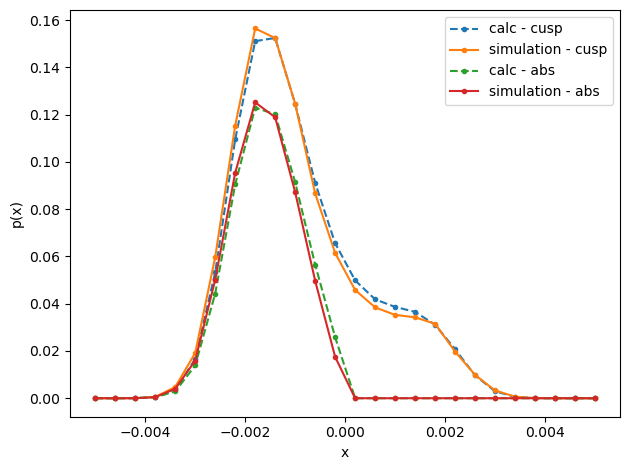

In [84]:
idx = N_t-1
plt.plot(x_s,hists[idx],'.--', label='calc - cusp')
plt.plot(x_s,sim_hists[(ntau+idx+1)*f]/N_p,'.-', label = 'simulation - cusp')

plt.plot(x_s,np.prod(unaltered_props_abs)*hists_abs[idx],'.--', label='calc - abs')
plt.plot(x_s,sim_hists_abs[(ntau+idx+1)*f]/N_p,'.-', label = 'simulation - abs')

plt.xlabel('x')
plt.ylabel('p(x)')

#plt.vlines((x_s[i_zero], 0), *plt.ylim(), color=['r','b'])
plt.legend()
plt.tight_layout()

(0.0, 1.0)

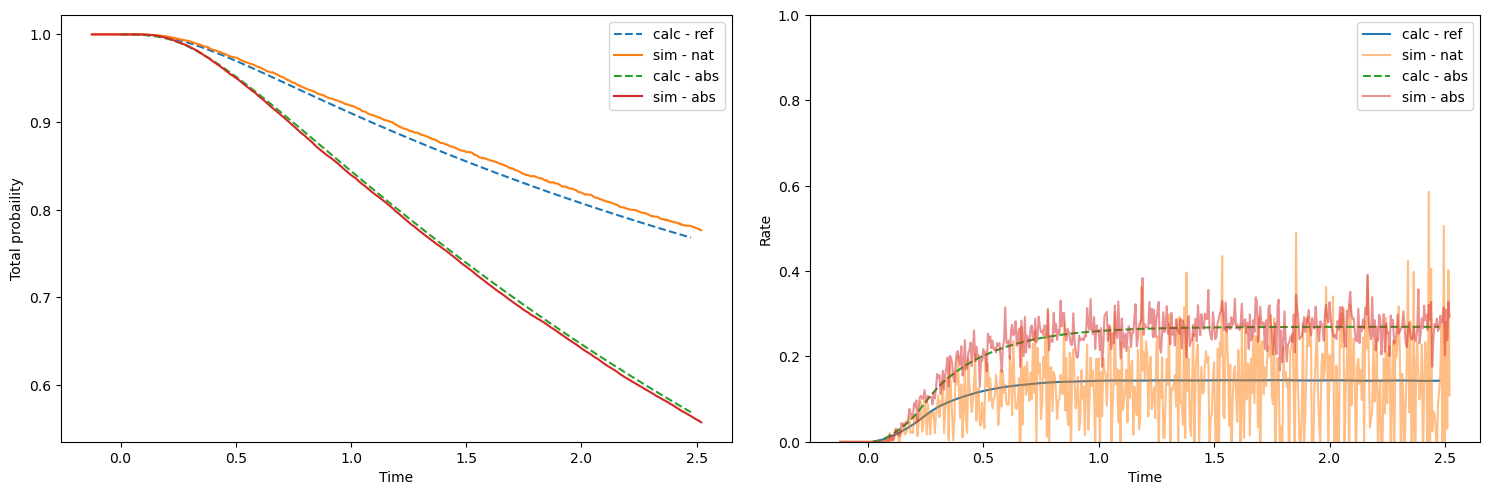

In [85]:
sur = 1-np.sum(hists[:,x_s > 0],axis = 1)
sur_sim = 1-np.sum(pos > 0, axis = (0,1))/N_p
s_abs = np.cumprod(unaltered_props_abs)[1:]
s_abs_sim = (np.sum(~np.isnan(pos_abs), axis=1)/N_p)[0]

rate = -np.diff(sur)/(2*sur[:-1]-1)/dt
rate_sim = -np.diff(sur_sim)/(2*sur_sim[:-1]-1)/(dt/f)
r_abs = -np.diff(np.log(s_abs))/dt
r_abs_sim = -np.diff(np.log(s_abs_sim))/(dt/f)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ts,sur,'--', label='calc - ref')
plt.plot(ts_sim,sur_sim, label='sim - nat')
plt.plot(ts, s_abs,'--', label='calc - abs')
plt.plot(ts_sim,s_abs_sim, label = 'sim - abs')
plt.xlabel('Time')
plt.ylabel('Total probaility')
plt.legend()


plt.subplot(122)
plt.plot(ts[1:],rate, label='calc - ref')
plt.plot(ts_sim[1:],rate_sim,alpha = 0.5,label='sim - nat')
plt.plot(ts[1:],r_abs,'--', label='calc - abs')
plt.plot(ts_sim[1:],r_abs_sim, alpha = 0.5,label = 'sim - abs')
plt.xlabel('Time')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.ylim(0,1)

In [86]:
tau*10

1.0

In [87]:
eq_t = 10*tau
m_r = np.nanmean(rate[ts[1:] > eq_t])
m_r_sim = rate_sim[ts_sim[1:] > eq_t].mean()
m_r_abs = r_abs[ts[1:] > eq_t].mean()
m_r_abs_sim = r_abs_sim[ts_sim[1:] > eq_t].mean()

print('calc cusp: \t',m_r)
print('sim cusp: \t', m_r_sim)
print('calc abs: \t',m_r_abs)
print('sim abs: \t', m_r_abs_sim)

calc cusp: 	 0.1435601418528325
sim cusp: 	 0.13602991149566357
calc abs: 	 0.2676352684944351
sim abs: 	 0.2696856618692906


In [88]:
print(m_r/m_r_sim)

1.05535716574666


In [89]:
print(m_r_abs/m_r_abs_sim)

0.9923970990498958


## rate of tau

In [7]:
k = 3
D = 1e-6
s = np.sqrt(2*D)
N_t = 75
dx = 4e-4

sb = 0.005

f = 3
N_p = 60_000


x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_border = np.argmin(x_s**2) + 1 #(first after border) -> partices are going there nothing comes back
N_x = len(x_s)

v_min = -1e-6 #-1e-6
border = 0.003 #0.0018
def force(x):
    a = -v_min/border**4
    b = -2*v_min/border**2
    return -4*a*x**3+2*b*x
i_zero = np.argmin((x_s+border)**2)

# border = 0.002 #0.0014
# def cusp_force(x):
#     if x < 0:
#         return -k*(x+border)
#     else:
#         return -k*(x-border)
# force = np.vectorize(cusp_force)
# i_zero = np.argmin((x_s+border)**2)

all_res = []
all_res_abs = []

all_sim_res = []
all_sim_res_abs = []
taus = np.arange(0,0.61,0.1)

for tau in tqdm(taus):
    dt = tau/4 if tau > 0 else taus[1]/4
    ntau = round(tau/dt)
    ts = np.arange(0,N_t)*dt
    prop = get_prop_v2(x_s, force,D,dt,dx,)
    prop_abs = get_prop_abs_v2(x_s, force,D,dt,dx,N_border)

    all_res.append([ts,*get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop)])
    all_res_abs.append([ts,*get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop_abs)])





    ts_sim = np.arange(0,(N_t+ntau+2)*f)*dt/f-tau-dt
    pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=border, force=force)
    pos_abs = pos.copy()
    for i in range(ntau+1, pos.shape[-1]):
        pos_abs[pos_abs[:,:,i] > 0,i:] = np.nan

    all_pos = pos[0]
    sim_hists = np.stack([np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))])

    all_pos_abs = pos_abs[0]
    sim_hists_abs = np.stack([np.histogram(all_pos_abs[:,j], bins = bins)[0] for j in tqdm(range(all_pos_abs.shape[-1]))])
    
    all_sim_res.append([ts_sim, sim_hists])
    all_sim_res_abs.append([ts_sim, sim_hists_abs])
    
all_all_res = [all_res, all_res_abs, all_sim_res,all_sim_res_abs]
with open('nummeric_results/dv_res_v2.pkl', 'wb') as file:
    pickle.dump({
        'k':k,
        'D':D,
        'N_t':N_t,
        'border':border,
        'dx':dx,
        'sb':sb,
        'f':f,
        'N_p':N_p,        
        'taus':taus,
        'all_all_res':all_all_res},file)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (26,)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (13,)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (9024,)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (6597,)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (21054,)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (13277,)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (34332,)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (20119,)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (48433,)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (27081,)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (63205,)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (33633,)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (78315,)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (39980,)


  0%|          | 0/230 [00:00<?, ?it/s]

/tmp/ipykernel_15381/890570087.py:23: RuntimeWarning: overflow encountered in multiply
  return -4*a*x**3+2*b*x
/tmp/ipykernel_15381/890570087.py:23: RuntimeWarning: overflow encountered in power
  return -4*a*x**3+2*b*x
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/td_algorithm_funcs.py:89: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
/tmp/ipykernel_15381/890570087.py:23: RuntimeWarning: invalid value encountered in add
  return -4*a*x**3+2*b*x


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

In [8]:
#pickle_obj =  pickle.load(open('nummeric_results/dv_res.pkl', 'rb') )
pickle_obj =  pickle.load(open('nummeric_results/dv_res_v2.pkl', 'rb') )
#pickle_obj =  pickle.load(open('nummeric_results/cusp_res.pkl', 'rb') )
#pickle_obj =  pickle.load(open('nummeric_results/cusp_res_high_border.pkl', 'rb') )
#pickle_obj =  pickle.load(open('nummeric_results/dv_res_high_border.pkl', 'rb') )
k = pickle_obj['k']
D = pickle_obj['D']
N_t = pickle_obj['N_t']
dx = pickle_obj['dx']
sb = pickle_obj['sb']
f = pickle_obj['f']
N_p = pickle_obj['N_p']
taus = pickle_obj['taus']
all_all_res = pickle_obj['all_all_res']

s = np.sqrt(2*D)
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_border = np.argmin(x_s**2) + 1 #(first after border) -> partices are going there nothing comes back
N_x = len(x_s)

$\dot{s_l} = - \kappa s_l + \kappa s_r$

$\kappa = \frac{\dot{s_l}}{(s_l - s_r)} $

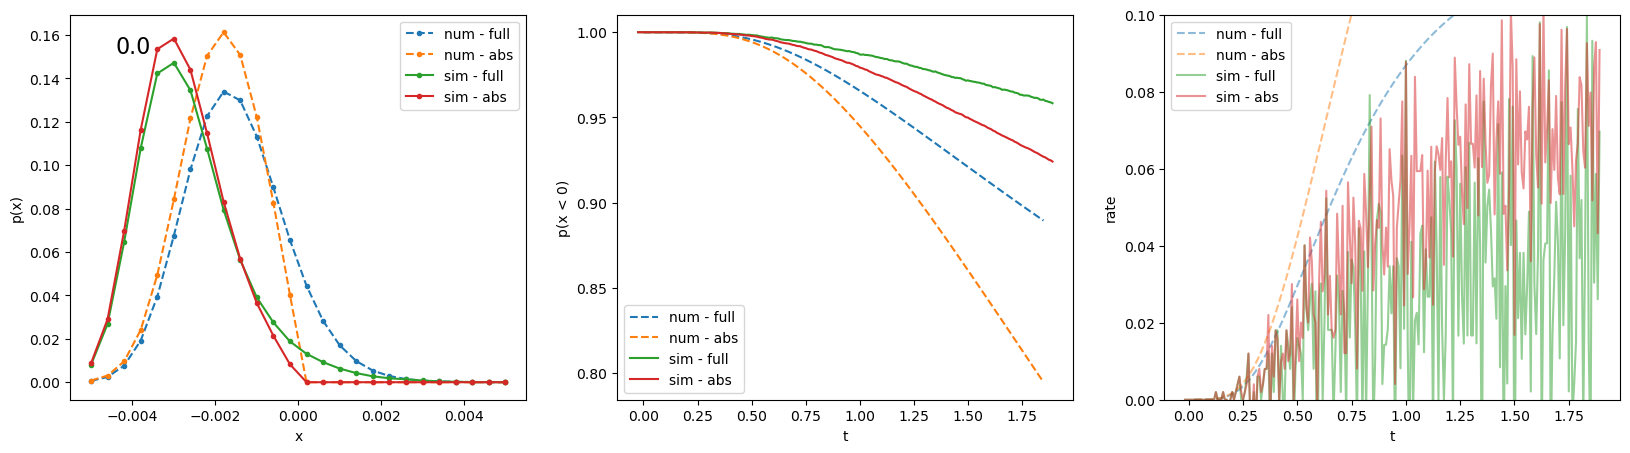

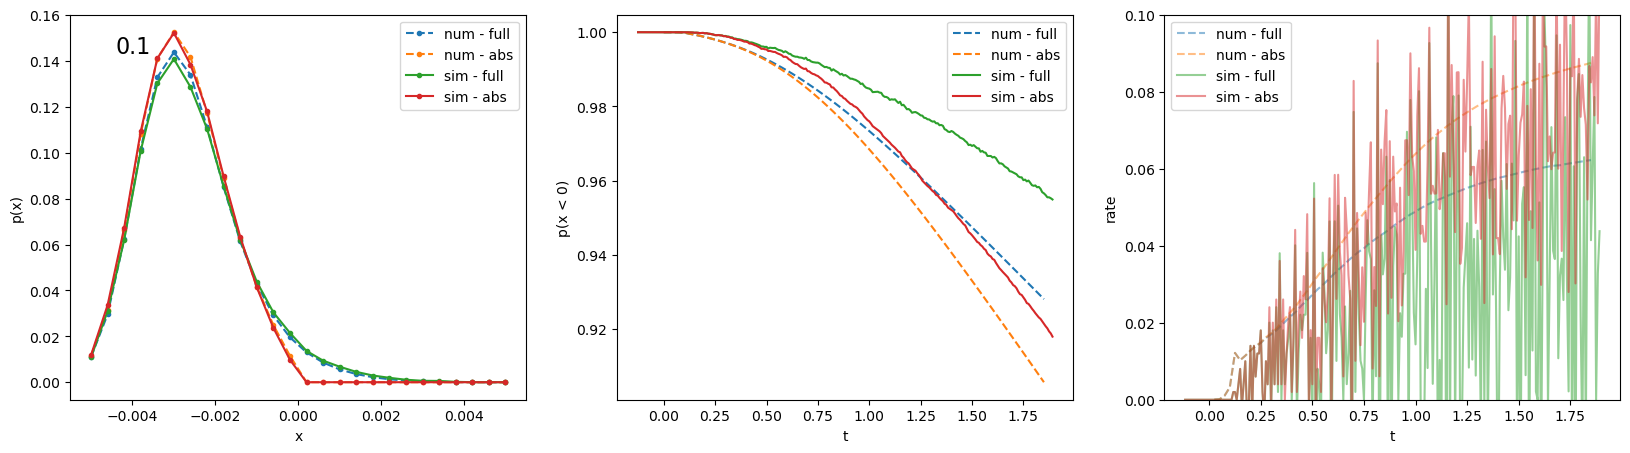

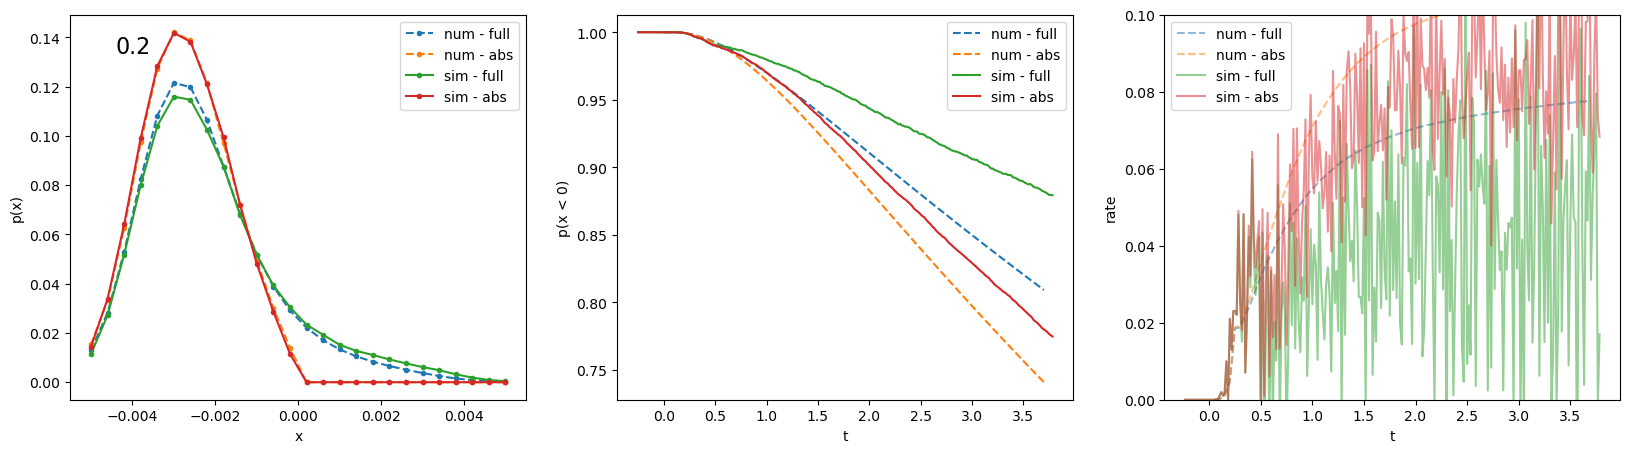

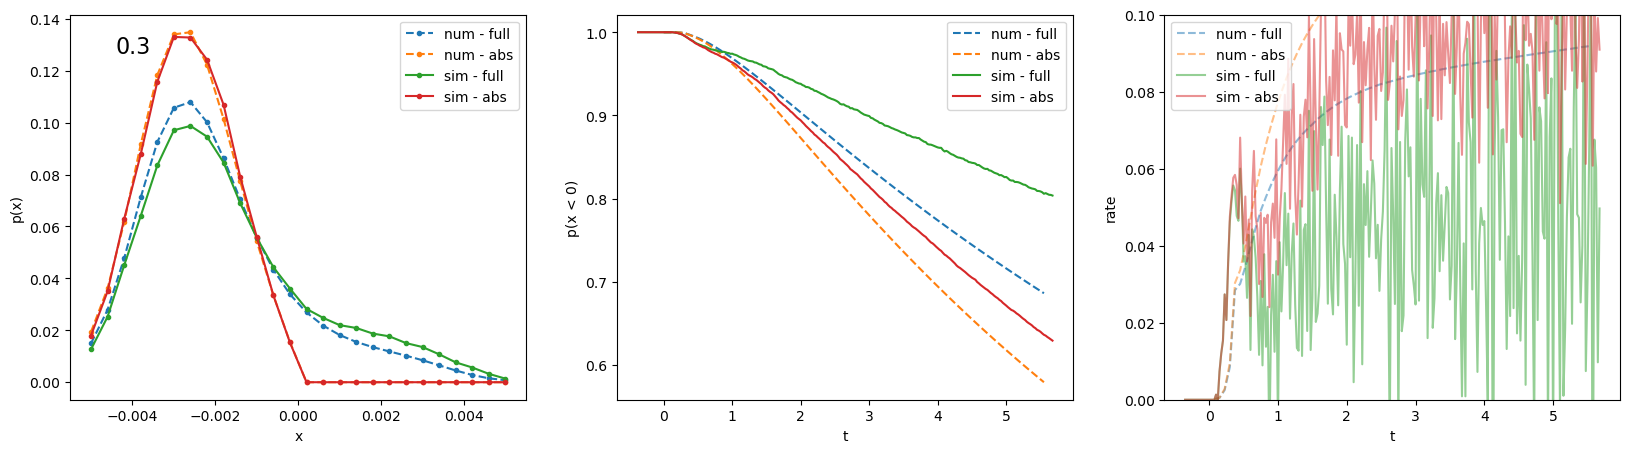

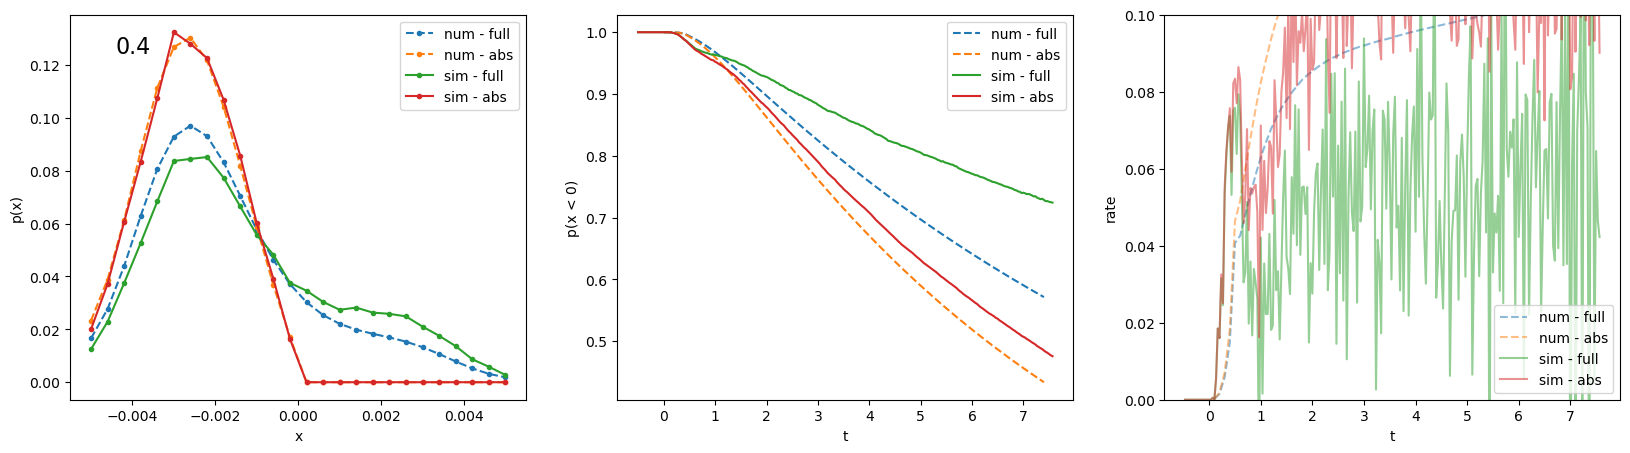

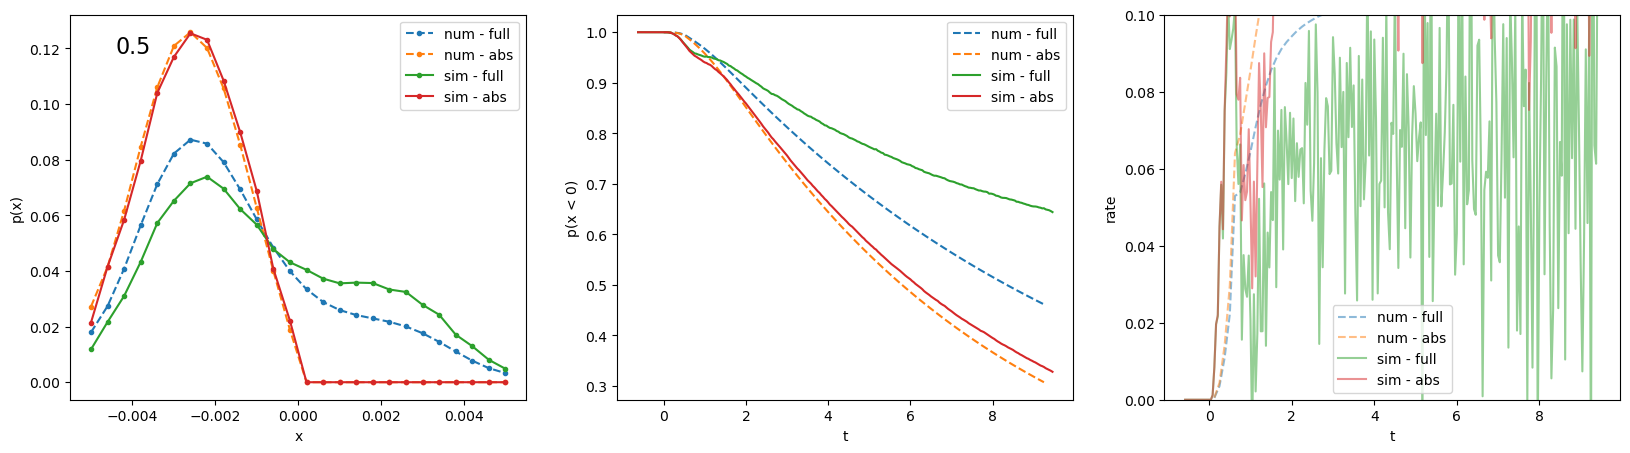

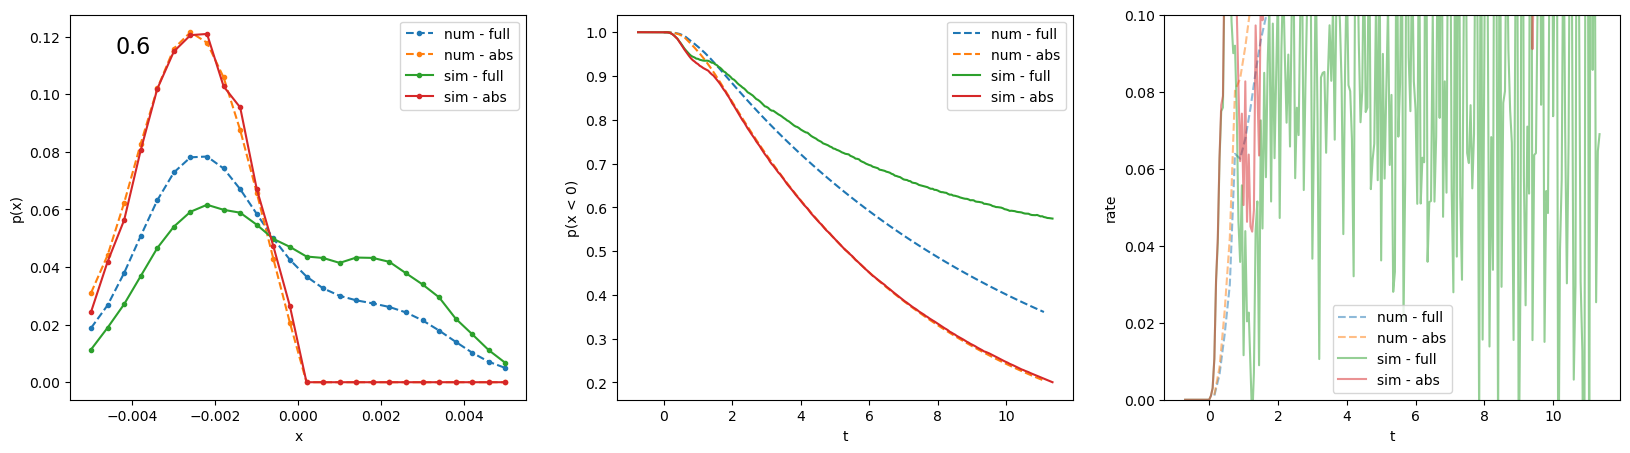

In [9]:
ls_s= ['--','--','-','-']
labels = ['num - full','num - abs', 'sim - full', 'sim - abs']
m_r = np.empty((len(taus), len(all_all_res)))

for tau_i,ltau in enumerate(taus):
    plt.figure(figsize=(20,5))
    for j,(all_r,ls, label) in enumerate(zip(all_all_res, ls_s, labels)):
        dt = all_r[tau_i][0][1]-all_r[tau_i][0][0]
        if len(all_r[0]) > 2:
            s,r = get_rate(np.stack(all_r[tau_i][1]), x_s, dt, total_props = all_r[tau_i][3])
        else:
            s,r = get_rate(np.stack(all_r[tau_i][1]), x_s,dt)


        plt.subplot(131)
        plt.plot(x_s,all_r[tau_i][1][-1]/np.sum(all_r[tau_i][1][-1]), ls = ls, marker = '.', label = label)
        plt.legend()
        
        plt.subplot(132)
        plt.plot(all_r[tau_i][0],s, ls=ls, label = label)
        plt.legend()
        
        plt.subplot(133)
        plt.plot(all_r[tau_i][0][1:],r,ls=ls, alpha = 0.5, label = label)
        plt.ylim(0,0.1)
        plt.legend()
        
        m_r[tau_i, j] = r[all_r[tau_i][0][1:] > taus[tau_i]*10].mean()
        
    ax = plt.subplot(131)
    plt.text(0.1, 0.9, round(ltau,1),  transform = ax.transAxes, fontsize = 16)
    plt.xlabel('x')
    plt.ylabel('p(x)')
    
    plt.subplot(132)
    plt.xlabel('t')
    plt.ylabel('p(x < 0)')
    
    plt.subplot(133)
    plt.xlabel('t')
    plt.ylabel('rate')

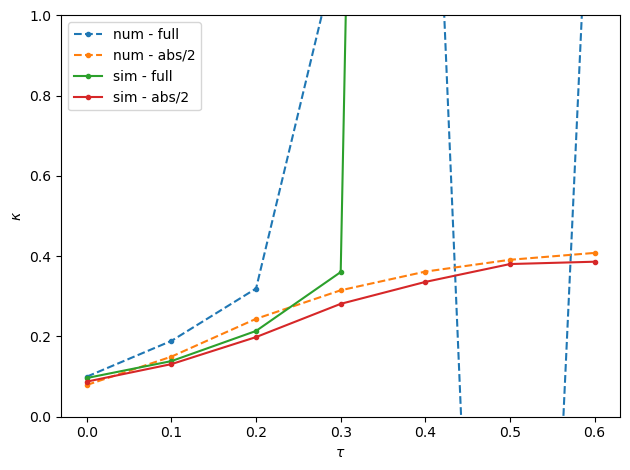

In [23]:
for i, (ls, label) in enumerate(zip(ls_s, labels)):
    if i%2:
        plt.plot(taus[:],m_r[:,i]/2, ls=ls, marker='.', label=label+"/2")
    else:
        plt.plot(taus[:],m_r[:,i], ls=ls, marker='.', label=label)
plt.ylim(0,1)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\kappa$')
plt.legend()
plt.tight_layout()
#plt.savefig('Graphic_Results/kappa_cusp_2dalgo.pdf')

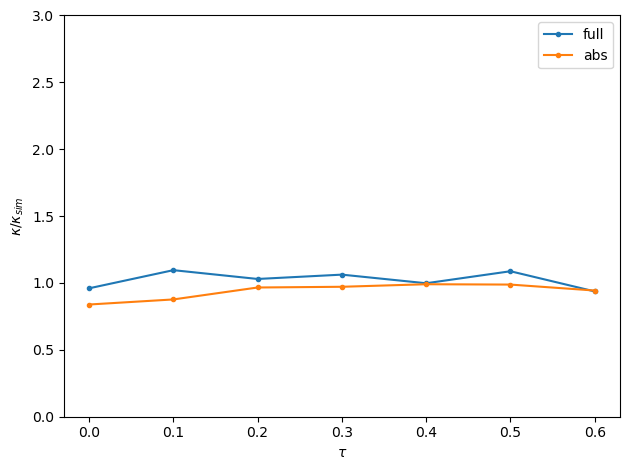

In [20]:
plt.plot(taus[:],m_r[:,0]/m_r[:,2] , marker='.', label='full')
plt.plot(taus[:],m_r[:,1]/m_r[:,3] , marker='.', c = 'C1', label='abs')
plt.ylim(0,3)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\kappa/\kappa_{sim}$')
plt.legend()
plt.tight_layout()
#plt.savefig('Graphic_Results/kappa_cusp_2dalgo_ratios.pdf')